In [2]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix

# Define dataset paths
dataset_path = "/kaggle/input/chest-xray-pneumonia/chest_xray"
train_dir = os.path.join(dataset_path, "train")
val_dir = os.path.join(dataset_path, "val")
test_dir = os.path.join(dataset_path, "test")

image_size = (224, 224)
batch_size = 32

# Data Generators
train_datagen_no_aug = ImageDataGenerator(rescale=1./255)
train_datagen_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator_no_aug = train_datagen_no_aug.flow_from_directory(
    train_dir, target_size=image_size, batch_size=batch_size, class_mode='binary', shuffle=True)

train_generator_aug = train_datagen_aug.flow_from_directory(
    train_dir, target_size=image_size, batch_size=batch_size, class_mode='binary', shuffle=True)

val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=image_size, batch_size=batch_size, class_mode='binary', shuffle=False)

test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=image_size, batch_size=batch_size, class_mode='binary', shuffle=False)

# Class Weight Calculation
train_pneumonia = len(os.listdir(os.path.join(train_dir, "PNEUMONIA")))
train_normal = len(os.listdir(os.path.join(train_dir, "NORMAL")))
total = train_pneumonia + train_normal
class_weights = {0: total / (2 * train_normal), 1: total / (2 * train_pneumonia)}

def build_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    model = Sequential([
        base_model,
        Dropout(0.3),  # Added Dropout to prevent overfitting
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.001)),  # Added L2 regularization
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

# Train model without augmentation, but with regularization



Found 5216 images belonging to 2 classes.
Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


VGG16 BEFORE AUGMENTATION- AFTER REMOVING BACKGROUND

In [3]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
def remove_background_otsu(image_path, save=False):
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    gray = clahe.apply(gray)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    _, mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((7, 7), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=3)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
    
    mask_cleaned = np.zeros_like(mask)
    cv2.drawContours(mask_cleaned, contours, -1, (255), thickness=cv2.FILLED)
    
    h, w = mask.shape
    top_cut = int(h * 0.20)
    mask_cleaned[:top_cut, :] = 0
    
    segmented = cv2.bitwise_and(gray, gray, mask=mask_cleaned)
    segmented = cv2.merge([segmented, segmented, segmented])
    
    img_no_bg = cv2.resize(segmented, (224, 224))
    img_no_bg = img_no_bg.astype(np.float32) / 255.0  # Normalize Properly

    return img_no_bg

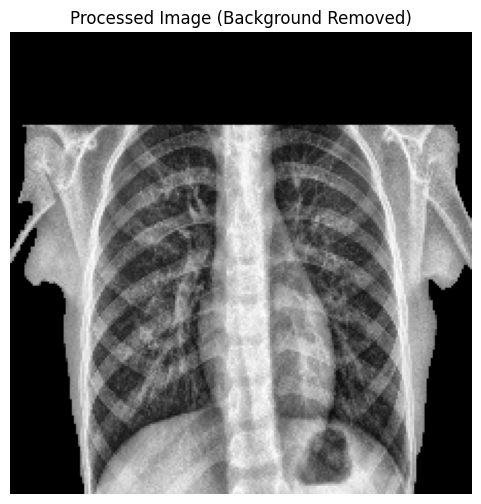

In [5]:
import matplotlib.pyplot as plt

# Path to your image
image_path = "/kaggle/input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0001-0001.jpeg"

# Process the image
processed_img = remove_background_otsu(image_path)

# Check if the image was processed correctly
if processed_img is not None:
    # Convert from BGR to RGB for correct visualization in Matplotlib
    processed_img_rgb = cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(processed_img_rgb)
    plt.axis("off")  # Hide axis
    plt.title("Processed Image (Background Removed)")
    plt.show()
else:
    print("Error: Could not process the image. Check the file path.")


In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

class CustomDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, file_paths, labels, batch_size=32, augment=False, visualize=False):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.augment = augment
        self.visualize = visualize
        self.visualization_done = False  # Track if visualization has been shown
        
        if self.augment:
            self.datagen = ImageDataGenerator(
                rotation_range=20,
                width_shift_range=0.2,
                height_shift_range=0.2,
                shear_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode='nearest')
        else:
            self.datagen = ImageDataGenerator()

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_files = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        
        batch_images = []
        valid_labels = []

        for img_path, label in zip(batch_files, batch_labels):
            img = remove_background_otsu(img_path, save=False)  # Otsu background removal
            
            if img is None:
                print(f"Warning: Background removal failed for {img_path}")  # Debugging
                continue  # Skip this image

            batch_images.append(img)
            valid_labels.append(label)

        if len(batch_images) == 0:
            raise ValueError("No valid images found in batch!")

        batch_images = np.array(batch_images, dtype=np.float32)  # Don't divide by 255.0 manually
        valid_labels = np.array(valid_labels)

        if self.visualize and not self.visualization_done:  # Only visualize once
            self.visualize_images(batch_images)
            self.visualization_done = True  # Set flag so it doesn't repeat

        # If augmentation is enabled, apply it and return the batch
        if self.augment:
            return next(self.datagen.flow(batch_images, valid_labels, batch_size=len(batch_images), shuffle=True))
        
        return batch_images, valid_labels

    def visualize_images(self, images, num_images=3):
        """Visualize first few processed images before augmentation."""
        fig, axes = plt.subplots(1, num_images, figsize=(10, 5))
        for i in range(num_images):
            axes[i].imshow(images[i])
            axes[i].axis("off")
        
        plt.suptitle("Otsu Background Removed X-rays (First Few Samples)")
        plt.show()


In [7]:
import os
def load_dataset(base_dir):
    """
    Loads dataset file paths and corresponding labels.
    """
    categories = ["NORMAL", "PNEUMONIA"]
    file_paths, labels = [], []

    for label, category in enumerate(categories):
        category_path = os.path.join(base_dir, category)
        for filename in os.listdir(category_path):
            file_paths.append(os.path.join(category_path, filename))
            labels.append(label)

    return file_paths, labels

# Define dataset directories
train_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
val_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/val"
test_dir = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"

# Load dataset paths and labels
train_files, train_labels = load_dataset(train_dir)
val_files, val_labels = load_dataset(val_dir)
test_files, test_labels = load_dataset(test_dir)


In [ ]:
def build_vgg16_with_gradcam():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

    # Grad-CAM model to extract last conv layer + output
    grad_model = tf.keras.Model(
        inputs=base_model.input,
        outputs=[base_model.get_layer('block5_conv3').output, model.output]
    )

    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model, grad_model

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Get unique class labels and their counts
unique_labels = np.unique(train_labels)
class_weights = compute_class_weight(class_weight="balanced", classes=unique_labels, y=train_labels)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print("Computed Class Weights:", class_weight_dict)

In [ ]:
from tensorflow.keras.applications import VGG16

train_generator_no_bg = CustomDataGenerator(train_files, train_labels, augment=False, visualize=True)
train_generator_aug_no_bg = CustomDataGenerator(train_files, train_labels, augment=True, visualize=True)

val_generator_no_bg = CustomDataGenerator(val_files, val_labels, augment=False)
val_generator_aug_no_bg = CustomDataGenerator(val_files, val_labels, augment=True)

test_generator_no_bg = CustomDataGenerator(test_files, test_labels, augment=False)

model_no_bg, grad_model_no_bg = build_vgg16_with_gradcam()
history_no_bg = model_no_bg.fit(
    train_generator_no_bg,
    validation_data=val_generator_no_bg,
    epochs=10,
    class_weight=class_weight_dict
)


In [ ]:
import cv2
import matplotlib.pyplot as plt

def generate_gradcam(img_array, grad_model, class_idx=None):
    img_array = tf.cast(img_array, tf.float32)
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # Get gradients of the output wrt conv layer
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # (channels,)

    # Multiply each channel by its corresponding gradient importance
    conv_outputs = conv_outputs[0]  # shape: (H, W, channels)
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]  # shape: (H, W, 1)
    heatmap = tf.squeeze(heatmap)  # shape: (H, W)

    # Normalize to 0–1
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap + tf.keras.backend.epsilon())

    return heatmap.numpy()

In [ ]:
def show_gradcam_on_image(img, heatmap, alpha=0.5):
    import cv2
    import numpy as np

    # Normalize image if it's float32
    if img.dtype == np.float32 or img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)

    # Make sure image is 3-channel
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    elif img.shape[-1] == 1:
        img = cv2.cvtColor(img.squeeze(), cv2.COLOR_GRAY2BGR)

    # Resize heatmap to image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to 0–255 uint8
    heatmap = np.uint8(255 * heatmap)

    # Apply colormap (result is 3-channel)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Combine image and heatmap
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)

    return superimposed_img



# Example from test set
x_test, y_test = test_generator_no_bg[0]
img = x_test[0]
img_batch = np.expand_dims(img, axis=0)

heatmap = generate_gradcam(img_batch, grad_model_no_bg)
cam_result = show_gradcam_on_image(img, heatmap)
plt.imshow(cam_result)
plt.axis('off')
plt.title("Grad-CAM Result")
plt.show()


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Get true labels and predictions from the test set
y_true = test_labels  # assuming test_labels is a list/array of 0 and 1
y_pred_prob = model_no_bg.predict(test_generator_no_bg, verbose=0)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()

# If class labels were binary (0 = Normal, 1 = Pneumonia), use:
class_labels = ['NORMAL', 'PNEUMONIA']

# ========================
# 📈 Accuracy & Loss Curves
# ========================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_no_bg.history['accuracy'], label='Train Accuracy')
plt.plot(history_no_bg.history['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_no_bg.history['loss'], label='Train Loss')
plt.plot(history_no_bg.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# ====================
# 🔍 Confusion Matrix
# ====================
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ============================
# 🧾 Classification Report
# ============================
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# ============================
# 📉 ROC Curve & AUC Score
# ============================
fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc, color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


VGG16 WITH AUG- AFTER REMOVING BG

In [ ]:
train_generator_aug_no_bg = CustomDataGenerator(train_files, train_labels, augment=True, visualize=True)
val_generator_aug_no_bg = CustomDataGenerator(val_files, val_labels, augment=True)
test_generator_no_bg = CustomDataGenerator(test_files, test_labels, augment=False)

# ======================
# 🔨 Build & Train Model
# ======================
model_aug_no_bg, grad_model_aug_no_bg = build_vgg16_with_gradcam()
history_aug_no_bg = model_aug_no_bg.fit(
    train_generator_aug_no_bg,
    validation_data=val_generator_aug_no_bg,
    epochs=10,
    class_weight=class_weight_dict
)

In [ ]:
y_pred_prob = model_aug_no_bg.predict(test_generator_no_bg, verbose=0)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()
y_true = test_labels
class_labels = ['NORMAL', 'PNEUMONIA']

# Accuracy & Loss Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_aug_no_bg.history['accuracy'], label='Train Accuracy')
plt.plot(history_aug_no_bg.history['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_aug_no_bg.history['loss'], label='Train Loss')
plt.plot(history_aug_no_bg.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc, color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [ ]:
def generate_gradcam(img_array, grad_model, class_idx=None):
    img_array = tf.cast(img_array, tf.float32)
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap + tf.keras.backend.epsilon())
    return heatmap.numpy()

def overlay_gradcam(img_array, heatmap, alpha=0.5):
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    original_img = (img_array[0] * 255).astype(np.uint8)
    superimposed_img = cv2.addWeighted(original_img, 1 - alpha, heatmap_color, alpha, 0)
    return superimposed_img

# ======================
# 🧪 Example Grad-CAM Use
# ======================
img_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

heatmap = generate_gradcam(img_array, grad_model_aug_no_bg)
superimposed = overlay_gradcam(img_array, heatmap)

plt.figure(figsize=(10, 5))
plt.imshow(superimposed)
plt.title("Grad-CAM Overlay")
plt.axis("off")
plt.show()


In [ ]:
import cv2
import matplotlib.pyplot as plt

def generate_gradcam(img_array, grad_model, class_idx=None):
    img_array = tf.cast(img_array, tf.float32)
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    # Get gradients of the output wrt conv layer
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # (channels,)

    # Multiply each channel by its corresponding gradient importance
    conv_outputs = conv_outputs[0]  # shape: (H, W, channels)
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]  # shape: (H, W, 1)
    heatmap = tf.squeeze(heatmap)  # shape: (H, W)

    # Normalize to 0–1
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap + tf.keras.backend.epsilon())

    return heatmap.numpy()
def show_gradcam_on_image(img, heatmap, alpha=0.5):
    import cv2
    import numpy as np

    # Normalize image if it's float32
    if img.dtype == np.float32 or img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)

    # Make sure image is 3-channel
    if img.ndim == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    elif img.shape[-1] == 1:
        img = cv2.cvtColor(img.squeeze(), cv2.COLOR_GRAY2BGR)

    # Resize heatmap to image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert heatmap to 0–255 uint8
    heatmap = np.uint8(255 * heatmap)

    # Apply colormap (result is 3-channel)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    # Combine image and heatmap
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)

    return superimposed_img



# Example from test set
x_test, y_test = test_generator_no_bg[0]
img = x_test[0]
img_batch = np.expand_dims(img, axis=0)

heatmap = generate_gradcam(img_batch, grad_model_aug_no_bg)
cam_result = show_gradcam_on_image(img, heatmap)
plt.imshow(cam_result)
plt.axis('off')
plt.title("Grad-CAM Result")
plt.show()


RESNET 50- BEFORE AUG-AFTER REMOVING BG


In [9]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
import numpy as np

# ======================
# 🔧 Setup Data Generators (NO AUGMENTATION)
# ======================
train_generator_no_bg = CustomDataGenerator(train_files, train_labels, augment=False)
val_generator_no_bg = CustomDataGenerator(val_files, val_labels, augment=False)
test_generator_no_bg = CustomDataGenerator(test_files, test_labels, augment=False)

# ======================
# ⚖️ Compute Class Weights
# ======================
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_labels),
                                     y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

# ======================
# 🔨 Build ResNet50 Model with Grad-CAM Support
# ======================
def build_resnet50_with_gradcam(fine_tune_layers=3, dropout_rate=0.4, learning_rate=1e-5, l2_reg=0.01):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    # Freeze all layers first
    for layer in base_model.layers:
        layer.trainable = False
    
    # Unfreeze last `fine_tune_layers` for fine-tuning
    for layer in base_model.layers[-fine_tune_layers:]:
        layer.trainable = True

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout_rate)(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Grad-CAM model for visualization
    grad_model = Model(inputs=base_model.input,
                       outputs=[base_model.get_layer('conv5_block3_out').output, model.output])

    model.compile(optimizer=Adam(learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.AUC()])

    return model, grad_model



In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
import numpy as np

# ======================
# 🔧 Data Generators (No Augmentation)
# ======================
train_generator_no_bg = CustomDataGenerator(train_files, train_labels, augment=False)
val_generator_no_bg = CustomDataGenerator(val_files, val_labels, augment=False)
test_generator_no_bg = CustomDataGenerator(test_files, test_labels, augment=False)

# ======================
# ⚖️ Class Weights
# ======================
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_labels),
                                     y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

# ======================
# 🔨 ResNet50 with More Fine-Tuning
# ======================
def build_resnet50_with_gradcam(fine_tune_layers=50, dropout_rate=0.3, learning_rate=1e-5, l2_reg=0.005):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-fine_tune_layers:]:
        layer.trainable = True

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout_rate)(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    grad_model = Model(inputs=base_model.input,
                       outputs=[base_model.get_layer('conv5_block3_out').output, model.output])

    model.compile(
        optimizer=Adam(learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05),
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )

    return model, grad_model

# ======================
# 🚀 Train with Callbacks
# ======================
model_no_aug, grad_model_no_aug = build_resnet50_with_gradcam()

callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)
]

history_no_aug = model_no_aug.fit(
    train_generator_no_bg,
    validation_data=val_generator_no_bg,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=callbacks
)


Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 152s 699ms/step - accuracy: 0.5607 - auc_3: 0.6492 - loss: 2.0010 - val_accuracy: 0.5000 - val_auc_3: 0.8203 - val_loss: 1.8676 - learning_rate: 1.0000e-05
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 651ms/step - accuracy: 0.8792 - auc_3: 0.9467 - loss: 1.5447 - val_accuracy: 0.2500 - val_auc_3: 0.2031 - val_loss: 2.0831 - learning_rate: 1.0000e-05
Epoch 3/10
 54/163 ━━━━━━━━━━━━━━━━━━━━ 1:20 738ms/step - accuracy: 0.9739 - auc_3: 0.9787 - loss: 1.3990

In [12]:
# ======================
# 🚀 Training with Callbacks
# ======================
# Build the model
model_no_aug, grad_model_no_aug = build_resnet50_with_gradcam()

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2)
]

# Train the model
history_no_aug = model_no_aug.fit(
    train_generator_no_bg,
    validation_data=val_generator_no_bg,
    epochs=10,
    class_weight=class_weight_dict,
    callbacks=callbacks
)

Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 155s 836ms/step - accuracy: 0.2914 - auc_2: 0.4395 - loss: 3.3340 - val_accuracy: 0.5000 - val_auc_2: 0.4844 - val_loss: 3.0539 - learning_rate: 1.0000e-05
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 657ms/step - accuracy: 0.4248 - auc_2: 0.5452 - loss: 3.1173 - val_accuracy: 0.5000 - val_auc_2: 0.3984 - val_loss: 3.0118 - learning_rate: 1.0000e-05
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 663ms/step - accuracy: 0.5107 - auc_2: 0.6294 - loss: 2.9585 - val_accuracy: 0.5000 - val_auc_2: 0.4766 - val_loss: 2.9336 - learning_rate: 1.0000e-05
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 666ms/step - accuracy: 0.5916 - auc_2: 0.6887 - loss: 2.8706 - val_accuracy: 0.4375 - val_auc_2: 0.5000 - val_loss: 2.8867 - learning_rate: 1.0000e-05
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 113s 655ms/step - accuracy: 0.6452 - auc_2: 0.7366 - loss: 2.7935 - val_accuracy: 0.4375 - val_auc_2: 0.5156 - val_loss: 2.8330 - learning_rate: 1.0000e-05
Epoch 6/10
163/163 ━

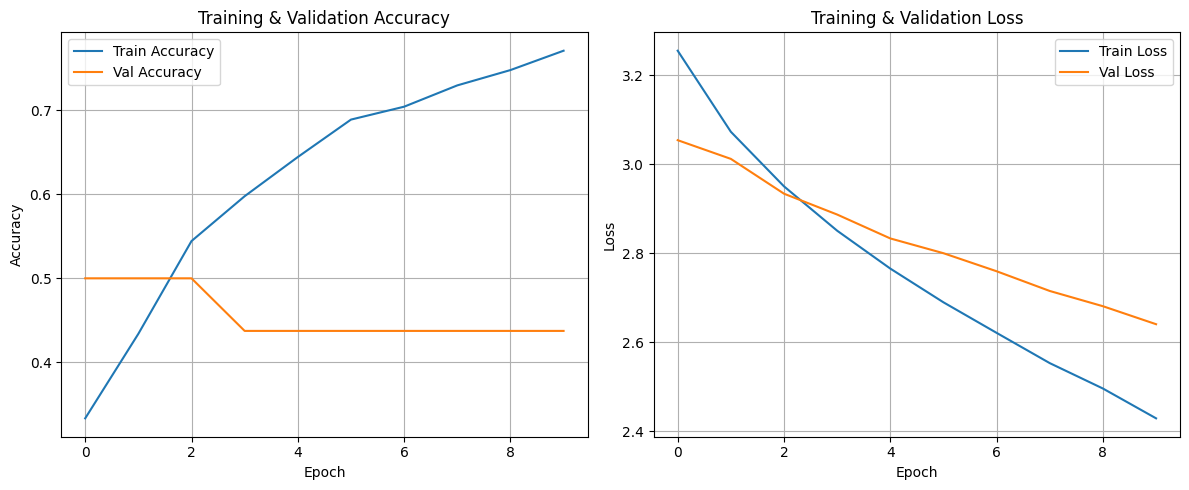

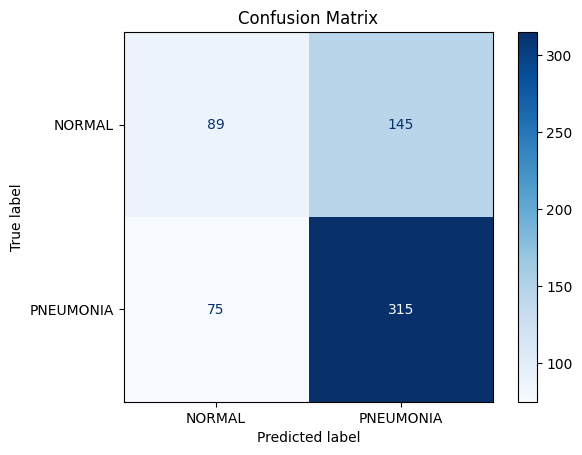

Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.54      0.38      0.45       234
   PNEUMONIA       0.68      0.81      0.74       390

    accuracy                           0.65       624
   macro avg       0.61      0.59      0.59       624
weighted avg       0.63      0.65      0.63       624



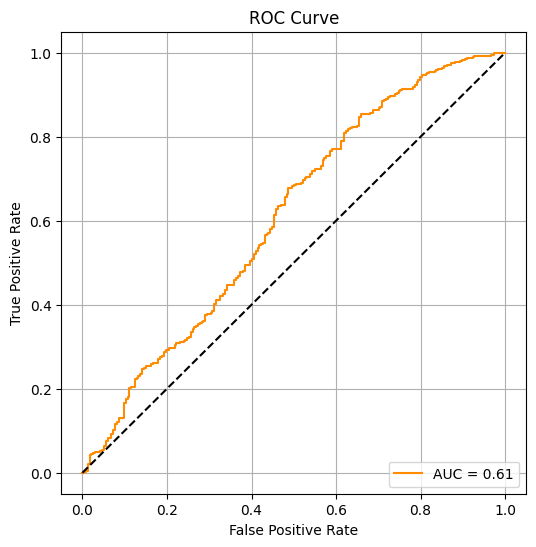

In [13]:
y_pred_prob = model_no_aug.predict(test_generator_no_bg, verbose=0)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()
y_true = test_labels
class_labels = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_no_aug.history['accuracy'], label='Train Accuracy')
plt.plot(history_no_aug.history['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history_no_aug.history['loss'], label='Train Loss')
plt.plot(history_no_aug.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc, color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

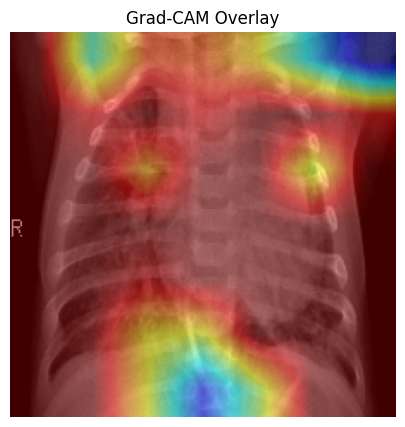

In [17]:
def generate_gradcam(img_array, grad_model, class_idx=None):
    img_array = tf.cast(img_array, tf.float32)
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap + tf.keras.backend.epsilon())
    return heatmap.numpy()

def overlay_gradcam(img_array, heatmap, alpha=0.5):
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    original_img = (img_array[0] * 255).astype(np.uint8)
    superimposed_img = cv2.addWeighted(original_img, 1 - alpha, heatmap_color, alpha, 0)
    return superimposed_img

# ======================
# 🧪 Example Grad-CAM Use
# ======================
img_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

heatmap = generate_gradcam(img_array, grad_model_no_aug)
superimposed = overlay_gradcam(img_array, heatmap)

plt.figure(figsize=(10, 5))
plt.imshow(superimposed)
plt.title("Grad-CAM Overlay")
plt.axis("off")
plt.show()


In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import cv2
import random

class CustomDataGenerator(Sequence):
    def __init__(self, file_paths, labels, batch_size=32, augment=False, shuffle=True):
        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size
        self.augment = augment
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.file_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_files = [self.file_paths[k] for k in batch_indexes]
        batch_labels = [self.labels[k] for k in batch_indexes]

        X = np.array([self.load_image(fp) for fp in batch_files])
        y = np.array(batch_labels).astype(np.float32)

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def load_image(self, filepath):
        image = cv2.imread(filepath)
        image = cv2.resize(image, (224, 224))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype(np.float32) / 255.0  # normalize to [0,1]

        if self.augment:
            image = self.augment_image(image)

        return image

    def augment_image(self, image):
        # Random horizontal flip
        if random.random() < 0.5:
            image = cv2.flip(image, 1)

        # Random rotation
        if random.random() < 0.5:
            angle = random.randint(-15, 15)
            h, w = image.shape[:2]
            M = cv2.getRotationMatrix2D((w / 2, h / 2), angle, 1)
            image = cv2.warpAffine(image, M, (w, h), borderMode=cv2.BORDER_REFLECT)

        # Random zoom
        if random.random() < 0.5:
            zoom_factor = random.uniform(1.0, 1.2)
            h, w = image.shape[:2]
            nh, nw = int(h / zoom_factor), int(w / zoom_factor)
            top = random.randint(0, h - nh)
            left = random.randint(0, w - nw)
            image = image[top:top + nh, left:left + nw]
            image = cv2.resize(image, (w, h))

        # Random brightness
        if random.random() < 0.5:
            factor = random.uniform(0.8, 1.2)
            image = np.clip(image * factor, 0, 1)

        return image


In [21]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
import numpy as np

# ======================
# 🔧 Data Generators (Augmented for Train, Clean for Val/Test)
# ======================
train_generator = CustomDataGenerator(train_files, train_labels, augment=True)
val_generator = CustomDataGenerator(val_files, val_labels, augment=False)
test_generator = CustomDataGenerator(test_files, test_labels, augment=False)

# ======================
# ⚖️ Class Weights
# ======================
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(train_labels),
                                     y=train_labels)
class_weight_dict = dict(enumerate(class_weights))

# ======================
# 🔨 ResNet50 with Fine-Tuning
# ======================
def build_resnet50_with_gradcam(fine_tune_layers=50, dropout_rate=0.3, learning_rate=1e-5, l2_reg=0.005):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    
    for layer in base_model.layers:
        layer.trainable = False
    for layer in base_model.layers[-fine_tune_layers:]:
        layer.trainable = True

    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(dropout_rate)(x)
    predictions = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Grad-CAM support
    grad_model = Model(inputs=base_model.input,
                       outputs=[base_model.get_layer('conv5_block3_out').output, model.output])

    model.compile(
        optimizer=Adam(learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )

    return model, grad_model




In [22]:
# ======================
# 🚀 Train (NO Callbacks, NO EarlyStopping)
# ======================
model, grad_model = build_resnet50_with_gradcam()

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weight_dict
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 333ms/step - accuracy: 0.7739 - auc_6: 0.8903 - loss: 1.6342 - val_accuracy: 0.5000 - val_auc_6: 0.5781 - val_loss: 1.9116
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 298ms/step - accuracy: 0.8979 - auc_6: 0.9662 - loss: 1.4305 - val_accuracy: 0.6875 - val_auc_6: 0.7656 - val_loss: 1.7021
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 297ms/step - accuracy: 0.9048 - auc_6: 0.9686 - loss: 1.4081 - val_accuracy: 0.7500 - val_auc_6: 0.7812 - val_loss: 1.7738
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 295ms/step - accuracy: 0.9214 - auc_6: 0.9787 - loss: 1.3527 - val_accuracy: 0.7500 - val_auc_6: 0.9062 - val_loss: 1.4822
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 293ms/step - accuracy: 0.9188 - auc_6: 0.9751 - loss: 1.3497 - val_accuracy: 0.7500 - val_auc_6: 0.9375 - val_loss: 1.5406
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 298ms/step - accuracy: 0.9231 - auc_6: 0.9772 - loss: 1.3269 - val_accuracy: 0.7500 - val_auc_6: 0.9531 - val_loss: 1.7486
Epoch 7/1

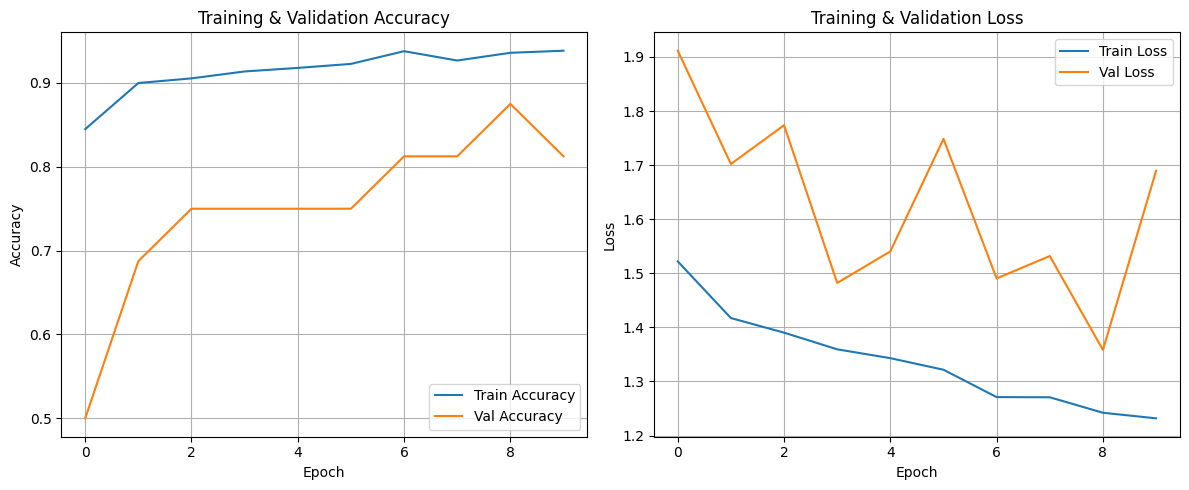

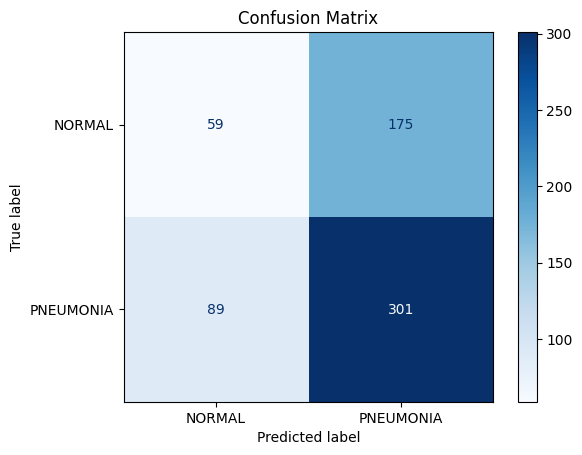

Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.40      0.25      0.31       234
   PNEUMONIA       0.63      0.77      0.70       390

    accuracy                           0.58       624
   macro avg       0.52      0.51      0.50       624
weighted avg       0.54      0.58      0.55       624



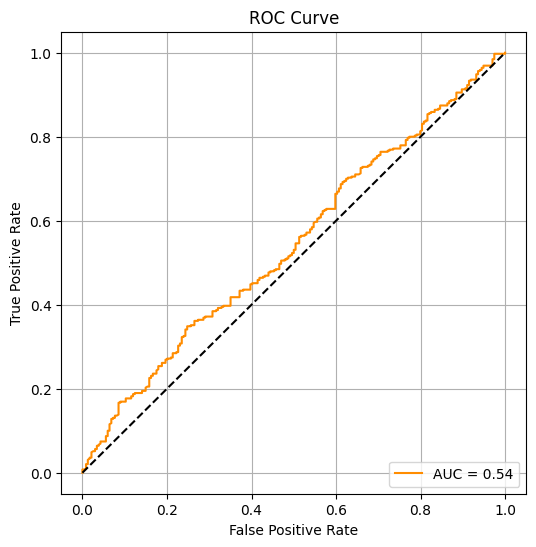

In [23]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import matplotlib.pyplot as plt

# ======================
# 📊 Evaluate Model on Test Set
# ======================
y_pred_prob = model.predict(test_generator, verbose=0)
y_pred = (y_pred_prob > 0.5).astype("int32").flatten()
y_true = test_labels
class_labels = ['NORMAL', 'PNEUMONIA']

# ======================
# 📈 Plot Accuracy & Loss Curves
# ======================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# ======================
# 🔄 Confusion Matrix
# ======================
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

# ======================
# 📝 Classification Report
# ======================
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

# ======================
# 📉 ROC Curve
# ======================
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}', color='darkorange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


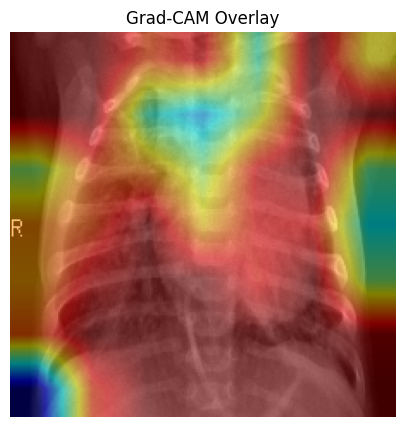

In [24]:
def generate_gradcam(img_array, grad_model, class_idx=None):
    img_array = tf.cast(img_array, tf.float32)
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap + tf.keras.backend.epsilon())
    return heatmap.numpy()

def overlay_gradcam(img_array, heatmap, alpha=0.5):
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    original_img = (img_array[0] * 255).astype(np.uint8)
    superimposed_img = cv2.addWeighted(original_img, 1 - alpha, heatmap_color, alpha, 0)
    return superimposed_img

# ======================
# 🧪 Example Grad-CAM Use
# ======================
img_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/person100_bacteria_475.jpeg'
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

heatmap = generate_gradcam(img_array, grad_model)
superimposed = overlay_gradcam(img_array, heatmap)

plt.figure(figsize=(10, 5))
plt.imshow(superimposed)
plt.title("Grad-CAM Overlay")
plt.axis("off")
plt.show()
